In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def take_best_n(items, n):
    return np.argpartition(items, -n)[-n:]

In [4]:
class EvolutionaryStrategy:
    
    def __init__(self, n, m, d, x0=None, v0=None):
        if x0 is None:
            x0 = np.random.uniform(-10, 10, size=(n, d))
        if v0 is None:
            v0 = np.abs(np.random.normal(size=(n, d)))
        
        self._x = x0
        self._v = v0
            
        self._m = m
        self._n = n
        self._d = d
    
    def ask(self):
        # Take m copies of each parent
        x = np.repeat(self._x, self._m, axis=0)
        v = np.repeat(self._v, self._m, axis=0)

        # Update variabilities
        theta = np.random.normal(size=v.shape)/self._d**0.5
        self._v = v*np.exp(theta)

        # Update positions
        self._x = x + v*np.random.normal(size=v.shape)

        return self._x, self._v
    
    def tell(self, fitness):
        idx = take_best_n(fitness, self._n)
        self._x = self._x[idx]
        self._v = self._v[idx]
        self._f = fitness[idx]
        
    def result(self):
        return self._x, self._v, self._f

In [5]:
def radial_fitness(x):
    return -np.sum(x**2, axis=-1)

opt = EvolutionaryStrategy(3, 5, 7)
x, v = opt.ask()
opt.tell(radial_fitness(x))
opt.result()


(array([[-0.79957583, -4.4953887 , -2.84455827, -5.24729067, -0.47792746,
          2.24691834,  6.793417  ],
        [-2.49559687, -4.40929713, -3.02870737, -4.79220918,  0.03108445,
          1.21297006,  6.83381183],
        [-2.45408321, -4.28921791, -3.14371027, -3.45662315,  0.45830529,
          0.47438838,  6.68200568]]),
 array([[0.7380553 , 0.12009037, 0.22910395, 0.89555927, 0.83674748,
         0.72321831, 2.32105208],
        [1.52902065, 0.1158063 , 0.50441728, 0.83148207, 0.50109339,
         0.57261549, 2.71961905],
        [0.83854252, 0.16332031, 0.40342529, 0.50245295, 0.62013685,
         0.92913336, 2.46612049]]),
 array([-107.9009834 , -105.9814888 ,  -91.33536052]))

In [6]:
def computational_experiment(fitness, n, m, n_iter=100, d=7, x0=None, v0=None):

    optimizer = EvolutionaryStrategy(n, m, d, x0=x0, v0=v0)

    history = []
    if x0 is not None and v0 is not None:
        history.append((x0, v0, fitness(x0)))

    for _ in range(n_iter):
        x, v = optimizer.ask()
        optimizer.tell(fitness(x))
        x, v, f = optimizer.result()
        history.append((x, v, f))

    history_x = np.stack([item[0] for item in history], axis=-1)
    history_v = np.stack([item[1] for item in history], axis=-1)
    history_f = np.stack([item[2] for item in history], axis=-1)

    return history_x, history_v, history_f

In [7]:
computational_experiment(radial_fitness, 3, 5)[0].shape

(3, 7, 100)

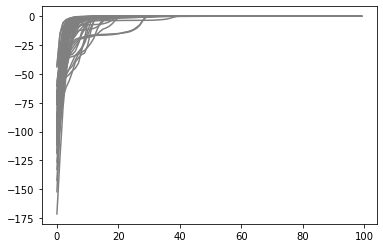

In [8]:
for _ in range(50):
    xs, vs, fs = computational_experiment(radial_fitness, 10, 100)
    plt.plot(fs.mean(axis=0), color="gray")

In [9]:
x0 = np.random.uniform(-3, 3, size=(5, 2))
v0 = 0.1*np.ones_like(x0)

xs, vs, fs = computational_experiment(radial_fitness, 5, 10, d=2)

In [10]:
x0

array([[-1.61432857, -1.39720179],
       [-0.72308682, -1.35592862],
       [ 0.15381521, -0.3709828 ],
       [-0.45784108, -2.82175581],
       [-2.43121449, -0.48905974]])

In [11]:
xs.shape

(5, 2, 100)

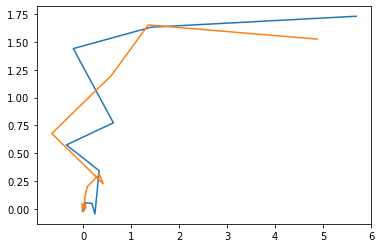

In [12]:
plt.plot(xs[0, 0, :], xs[0, 1, :])
plt.plot(xs[1, 0, :], xs[1, 1, :])

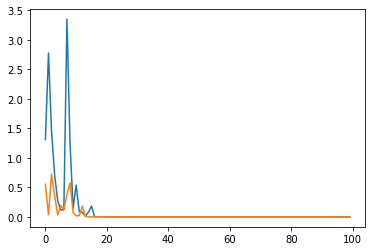

In [13]:
plt.plot(vs[0, 0, :])
plt.plot(vs[0, 1, :])

In [14]:
def has_converged(x, tol):
    delta_x = np.ptp(x[:, 0])
    delta_y = np.ptp(x[:, 1])
    return delta_x < tol and delta_y < tol

In [15]:
from matplotlib.animation import FuncAnimation, ArtistAnimation
from matplotlib.patches import Ellipse
from matplotlib import cm

from IPython import display

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim((-3, 3))
ax.set_ylim((-3, 3))

x_ = np.linspace(-3, 3)
y_ = np.linspace(-3, 3)
X, Y = np.meshgrid(x_, y_)
F = radial_fitness(np.stack((X, Y), axis=-1))
ax.contour(X, Y, F, cmap=cm.coolwarm, levels=10)

artists = []
for k in range(xs.shape[-1]):
    if has_converged(xs[:, :, k], tol=0.001):
        break
    
    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))
    x = xs[:, 0, k]
    y = xs[:, 1, k]
    
    a = [ax.scatter(x, y, color="red", zorder=2)]
    for cx, cy, vx, vy in zip(x, y, vs[:, 0, k], vs[:, 1, k]):
        a.append(ax.add_artist(Ellipse((cx, cy), 2*vx, 2*vy, ec="gray", fc="lightblue", alpha=0.5)))
    artists.append(a)
    
anim = ArtistAnimation(fig, artists, blit=True, interval=500)
anim.save("evolution-spherical.gif")

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close() 

In [17]:
def schwefel_fitness(x):
    s = -np.sum(x*np.sin(np.sqrt(np.abs(x))), axis=-1)
    
    # check that particles don't go outside
    mask = np.any(np.abs(x) > 500, axis=-1)
    s[mask] = np.inf
    
    return -s

In [18]:
n = 10
m = 100
d = 2

x0 = np.random.uniform(-400, 400, size=(n, d))
v0 = 10*np.ones_like(x0)

xs, vs, fs = computational_experiment(schwefel_fitness, n, m, d=2, x0=x0, v0=v0)

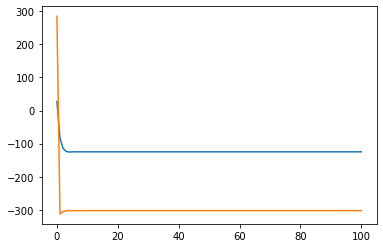

In [19]:
plt.plot(xs[0, 0, :])
plt.plot(xs[0, 1, :])

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim((-500, 500))
ax.set_ylim((-500, 500))

x_ = np.linspace(-500, 500, 100)
y_ = np.linspace(-500, 500, 100)
X, Y = np.meshgrid(x_, y_)
F = schwefel_fitness(np.stack((X, Y), axis=-1))
ax.contour(X, Y, F, cmap=cm.coolwarm, levels=10)

artists = []
for k in range(xs.shape[-1]):
    if has_converged(xs[:, :, k], tol=0.1):
        break
    
    x = xs[:, 0, k]
    y = xs[:, 1, k]
    
    a = [ax.scatter(x, y, color="red", zorder=2)]
    for cx, cy, vx, vy in zip(x, y, vs[:, 0, k], vs[:, 1, k]):
        a.append(ax.add_artist(Ellipse((cx, cy), 2*vx, 2*vy, ec="gray", fc="lightblue", alpha=0.5)))
    artists.append(a)
    
anim = ArtistAnimation(fig, artists, blit=True, interval=500)
anim.save("evolution-schwefel.mp4")

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close() 